In [45]:
# Reload and core imports
%reload_ext autoreload
%autoreload 2

# All-in-one imports
import numpy as np
from dolfin import *
from src.Optimiser import objective_function#, #spacing_constraint
from src.solver import (
    setup_swe_problem, setup_boundary_markers_and_bcs, solve_tidal_flow_velocities
)
from src.turbines import (
    place_turbines_random, compute_turbine_power, summarize_turbine_power, plot_turbine_layout
)
from src.plots import plot_velocity_field, compute_power_field_plot
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution
#from dolfin_adjoint import *

# PETSc (quiet mode)
from petsc4py import PETSc
PETSc.Options()["ksp_monitor"] = None
PETSc.Options()["ksp_view"] = None


print("✅ Thesis SWE solver ready (v15-12)")

✅ Thesis SWE solver ready (v15-12)


In [46]:
# --- Physical and turbine parameters ---
rho = 1025.0         # Water density [kg/m³]
g = 9.81             # Gravitational acceleration [m/s²]
depth = 50.0         # Water depth [m]

C_T = 0.6             # Turbine thrust coefficient [-]
C_D = 0.0025          # Drag coefficient [-]
sigma = 5.0          # Wake Gaussian spread [m]
D = 5               # Turbine diameter
A_T = np.pi*D**2            # Turbine swept area [m²]

# --- Flow properties ---
U_inflow = 2.0       # Inflow velocity [m/s]
nu_eff = Constant(1.0)  # Effective viscosity [m²/s]
cb = 0.0025    # Bed friction coefficient [-]
viscosity = 1.0 #for now keep turbulent visc or eddy visc

#H = depth  # total depth (assuming flat bottom for now)
nu = viscosity  # viscosity coefficient

# --- Initial conditions ---
initial_condition_u = Constant((0.0, 0.0))
initial_condition_eta = Constant(0.0) # Start with no surface elevation

#----Mesh parameters----
Lx, Ly = 500.0, 400.0
Nx, Ny = 50, 35

n_turbines = 10             # number of turbines
min_spacing = 5*D     # minimum spacing between turbines [m]
#random.seed(42)             # set a fixed seed for reproducibility

#----Showing plots or not----
mesh_plot = True
turbine_position_plot = True


print(f"Initialized base parameters successfully.")

Initialized base parameters successfully.


Success! Initialized u_init with U_inflow = 2.0 m/s on a 50x35 mesh.


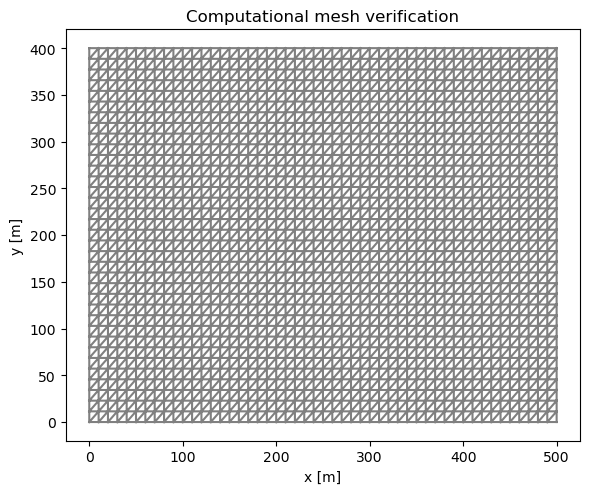

✅ Successfully placed 10 turbines after 11 attempts.
Initialized 10 turbines successfully.


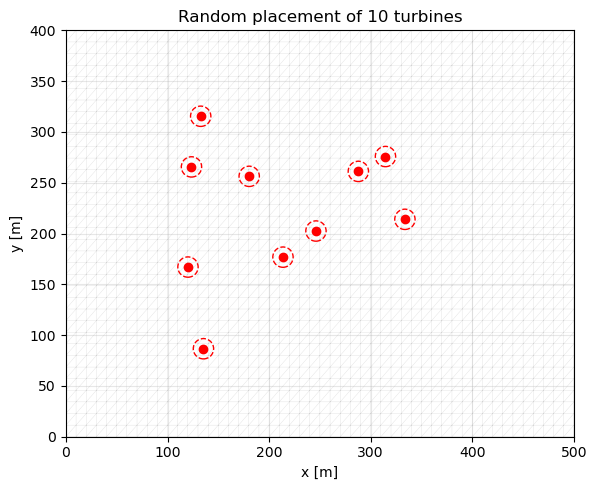

✅ Boundary markers created and BCs applied:
   - Inlet (ID=1): 2.0 m/s
   - Outflow (ID=2): marked for future use


In [47]:
#setting up mesh and initial turbine positions and boundary conditions and markers
mesh, W, w, u, eta, v, q, inflow, outflow, walls = setup_swe_problem(
    Lx, Ly, Nx, Ny, U_inflow, mesh_plot
)

turbine_positions = place_turbines_random(Lx, Ly, n_turbines, sigma, min_spacing)
x0 = np.array(turbine_positions).flatten() # Flatten initial turbine positions

plot_turbine_layout(mesh, turbine_positions, Lx, Ly, sigma, turbine_position_plot)
boundary_markers, bcs = setup_boundary_markers_and_bcs(mesh, W, Lx, U_inflow)

In [49]:
import numpy as np
import matplotlib.pyplot as plt

class OptimisationMonitor:
    def __init__(self, n_turbines, mesh, Lx, Ly, plot_interval=1):
        self.iter_count = 0
        self.history = []
        self.best_val = np.inf
        self.n_turbines = n_turbines
        self.mesh = mesh
        self.Lx = Lx
        self.Ly = Ly
        self.plot_interval = plot_interval  # every N iterations

    def __call__(self, xk, convergence):
        """
        Called automatically by SciPy after each iteration.

        Parameters
        ----------
        xk : ndarray
            Current best parameter vector (flattened positions).
        convergence : float
            Current convergence metric.
        """
        self.iter_count += 1
        n_t = self.n_turbines
        positions = xk.reshape(n_t, 2)

        # Store convergence data
        self.history.append((self.iter_count, -self.best_val))  # negative since we minimize -power

        print(f"\n🔁 Iteration {self.iter_count}: convergence = {convergence:.3e}")

        # Optional plotting every few iterations
        if self.iter_count % self.plot_interval == 0:
            plt.figure(figsize=(5, 5))
            plt.triplot(self.mesh)
            plt.scatter(positions[:, 0], positions[:, 1], c='r', label="Turbines")
            plt.xlim(0, self.Lx)
            plt.ylim(0, self.Ly)
            plt.legend()
            plt.title(f"Turbine layout iteration {self.iter_count}")
            plt.show()

        # Optional stop condition if no improvement
        if convergence < 1e-4:
            print("🛑 Early stopping: Convergence below threshold.")
            return True  # stop optimisation
        return False


In [48]:
import numpy as np
from scipy.optimize import differential_evolution
monitor = OptimisationMonitor(n_turbines=len(turbine_positions), mesh=mesh, Lx=Lx, Ly=Ly, plot_interval=1)

print("Shape of init_population:", init_population.shape)


# Convert turbine positions to NumPy array and flatten
x0 = np.array(turbine_positions).flatten()

# Number of variables and turbines
nvar = len(x0)
n_pop = 8  # at least 5
n_turbines = len(turbine_positions)

# Build an initial population array of shape (n_pop, nvar)
# First row is your current design; others are small perturbations
scale = 0.05  # 5% domain perturbation range
init_population = np.vstack([
    x0,
    x0 + np.random.uniform(-scale, scale, size=nvar) * np.array([Lx, Ly] * n_turbines),
    x0 + np.random.uniform(-scale, scale, size=nvar) * np.array([Lx, Ly] * n_turbines),
    x0 + np.random.uniform(-scale, scale, size=nvar) * np.array([Lx, Ly] * n_turbines),
    x0 + np.random.uniform(-scale, scale, size=nvar) * np.array([Lx, Ly] * n_turbines),
    x0 + np.random.uniform(-scale, scale, size=nvar) * np.array([Lx, Ly] * n_turbines),
    x0 + np.random.uniform(-scale, scale, size=nvar) * np.array([Lx, Ly] * n_turbines),
    x0 + np.random.uniform(-scale, scale, size=nvar) * np.array([Lx, Ly] * n_turbines)
])

# Define optimisation bounds and arguments
bounds = [(0, Lx), (0, Ly)] * n_turbines
args = (w, W, mesh, bcs, rho, depth, nu, cb, g, C_T, A_T, sigma, D)

# Run optimisation
result = differential_evolution(
    func=objective_function,
    bounds=bounds,
    args=args,
    init=init_population,   # ✅ correct shape (S, len(x)), S > 4
    maxiter=2,
    popsize=8,
    updating='immediate',
    workers=1,
    disp=True,
    polish=True,
)

# Reshape final layout
opt_positions = result.x.reshape(-1, 2)
print("Optimal turbine positions:\n", opt_positions)


Shape of init_population: (8, 20)
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.056e+00 (tol = 1.000e-08) r (rel) = 1.000e+00 (tol = 1.000e-07)
  Newton iteration 1: r (abs) = 5.144e-02 (tol = 1.000e-08) r (rel) = 2.502e-02 (tol = 1.000e-07)
  Newton iteration 2: r (abs) = 7.457e-05 (tol = 1.000e-08) r (rel) = 3.626e-05 (tol = 1.000e-07)
  Newton iteration 3: r (abs) = 1.682e-10 (tol = 1.000e-08) r (rel) = 8.181e-11 (tol = 1.000e-07)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
The total power is 1778.0 kW
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form 

KeyboardInterrupt: 

In [23]:
nvar = len(bounds)
x0 = np.array(turbine_positions).flatten()

# Create initial population including your design + random perturbations
popsize = 8
init_pop = np.vstack([
    x0,
    x0 + np.random.uniform(-10, 10, size=nvar),
    x0 + np.random.uniform(-20, 20, size=nvar),
    x0 + np.random.uniform(-30, 30, size=nvar),
    x0 + np.random.uniform(-40, 40, size=nvar),
])


# --- Define bounds ---
bounds = [(0.0, Lx), (0.0, Ly)] * len(turbine_positions)

# Physical parameters (fill in your constants)
args = (w, W, mesh, bcs, rho, depth, nu, cb, g, C_T, A_T, sigma, D)

# --- Run optimisation ---
result = differential_evolution(
    func=objective_function,
    bounds=bounds,
    args=args,
    init=[x0],
    maxiter=20,
    popsize=8,
    tol=1e-3,
    updating="deferred",
    workers=-1,   # if parallelism available
    disp=True,
    polish=True
)

# --- Extract optimal turbine locations ---
opt_positions = result.x.reshape(-1, 2)
print("Optimisation complete.")
print(f"Optimal layout:\n{opt_positions}")


ValueError: The population supplied needs to have shape (S, len(x)), where S > 4.

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.027e+00 (tol = 1.000e-08) r (rel) = 1.000e+00 (tol = 1.000e-07)
  Newton iteration 1: r (abs) = 5.399e-02 (tol = 1.000e-08) r (rel) = 2.663e-02 (tol = 1.000e-07)
  Newton iteration 2: r (abs) = 5.391e-05 (tol = 1.000e-08) r (rel) = 2.659e-05 (tol = 1.000e-07)
  Newton iteration 3: r (abs) = 1.028e-10 (tol = 1.000e-08) r (rel) = 5.072e-11 (tol = 1.000e-07)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
The total power is 1768.3 kW
Maximum theoretical power per turbine (Betz-adjusted): 135.25 kW
Momentum-sink (raw thrust) power per turbine:          193.21

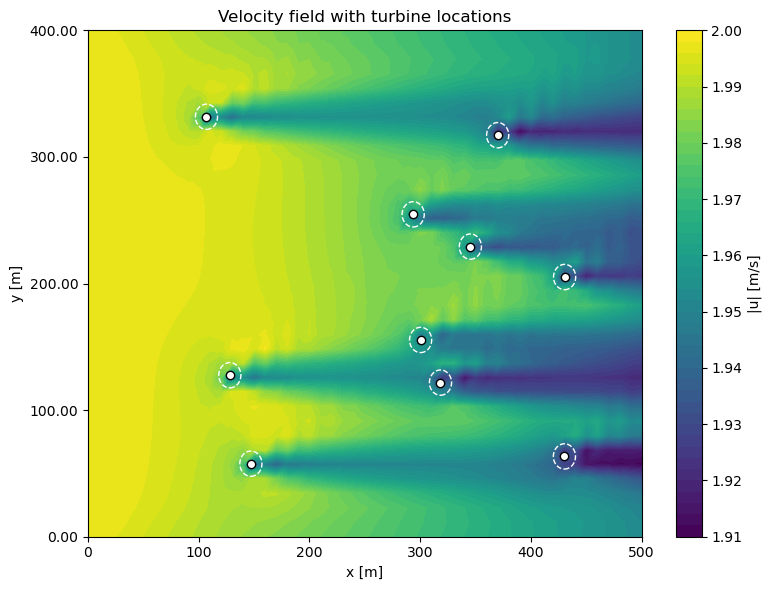

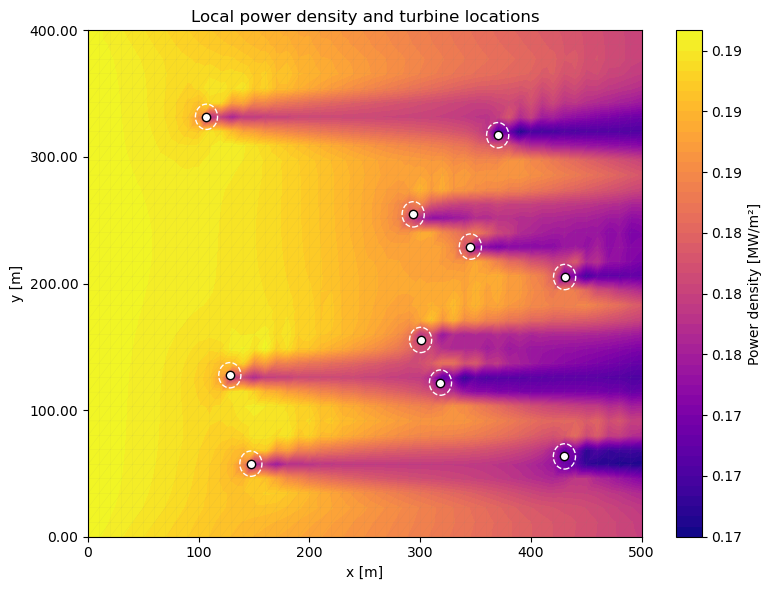

In [11]:
# Solve and get results (this already computes power and velocity)
total_power, velocity = solve_tidal_flow_velocities(
    turbine_positions,
    w,
    W,
    mesh,
    bcs,
    rho,
    depth,
    nu,
    cb,
    g,
    C_T,
    A_T,
    sigma,
)

# Additional turbine analysis (uses the velocity from solver)
turbine_powers, turbine_velocities = compute_turbine_power(
    velocity, turbine_positions, rho, C_T, A_T
)

total_power_check, Max_park_power, _, _ = summarize_turbine_power(
    turbine_powers, turbine_velocities, rho, C_T, A_T, U_inflow, n_turbines
)

print(f" total power (just to check) =", total_power_check)

print("-----------------------------------------")
print(f"Total power: {total_power/1e3:.1f} kW")
print(f"Max park power: {Max_park_power/1e6:.2f} MW")
print(f"Efficiency: {total_power/Max_park_power*100:.1f}%")

# Plots (use w directly - it contains the solved solution)
plot_velocity_field(w, turbine_positions, sigma)
compute_power_field_plot(C_T, rho, A_T, w, turbine_positions, sigma)
